# Top sights Palma model

In [1]:
import os
# os.chdir('../')
print(os.getcwd())

/home/mariadelmar/documents/madm/tfm/code/cruiseshiptourism


In [2]:
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tourist import Tourist 
import tasks as tsk
from vincenty import vincenty
import unidecode
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

First, we read the csv with google palma points of interest.

In [4]:
topsights = pd.read_csv(
            "palmadata/palmapointsofinterest.csv", 
            header = 0,
            dtype = {
                "place": 'str',
                "description": 'str',
                "latitude": 'float',
                "longitude": 'float',
                "stars": 'float',
                "reviews": 'float'
            }
        )

We add cruise ship location into topsights dataframe.  <br> Index must be 0.

In [5]:
shiprow = {"place": ["cruise ship"], 
           "description": ["tourist cruise ship"],
           "latitude": [39.568276],
           "longitude": [2.637640],
           "stars": [0], 
           "reviews": [0]}

shipdf = pd\
    .DataFrame(data=shiprow)\
    .astype(dtype={
                "place": "str",
                "description": "str",
                "latitude": "float",
                "longitude": "float",
                "stars": "float",
                "reviews": "float"
            })

topsights = pd.concat([shipdf,topsights]).reset_index(drop=True)

In [6]:
topsights.head()

,place,description,latitude,longitude,stars,reviews
0,cruise ship,tourist cruise ship,39.568276,2.637640,0.000000,0.0
1,Catedral-Basílica de Santa María de Mallorca,Gothic place of worship on the seafront,39.567425,2.648299,4.674750,31176.0
2,Castell de Bellver,Hilltop 1300s castle for panoramic views,39.563814,2.619354,4.436243,10446.0
3,Royal Palace of La Almudaina,Historic palace of the Royal Family,39.567886,2.647022,4.420346,2310.0
4,Palma Aquarium,Aquarium with huge shark-viewing tank,39.531374,2.729529,4.367786,14764.0


## Locations

There are locations outside from Palma. These locations must be removed.

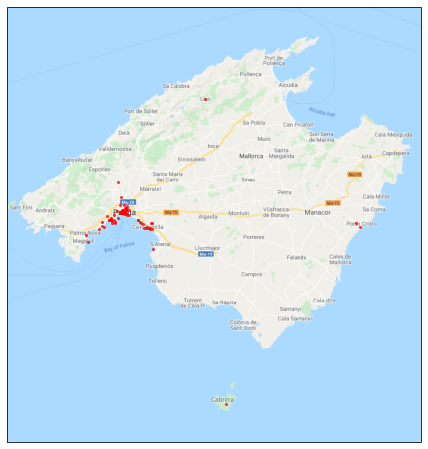

In [7]:
# values
latitude = topsights['latitude'].values
longitude = topsights['longitude'].values

# Map background
fig = plt.figure(figsize=(8, 8))

tiler = cimgt.GoogleTiles()
mercator = tiler.crs
ax = plt.axes(projection=mercator)

llcrnrlat=39.055777  # The lower left corner geographical latitude
llcrnrlon=2.310797   # The lower left corner geographical longitude
urcrnrlat=40.025957  # The upper right corner geographical latitude
urcrnrlon=3.508145   # The upper right corner geographical longitude

ax.set_extent([llcrnrlon,urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())

zoom = 10
ax.add_image(tiler, zoom )

plt.plot(longitude, latitude, marker='o', color='red', markersize=2, lw=0,
         alpha=0.7, transform=ccrs.Geodetic())

plt.show()

We define center of Palma and maximum distance from this point.

In [8]:
center = {"place":"center of Palma",
          "latitude": 39.571533,
          "longitude": 2.651444}
bellvercastle = topsights[topsights["place"]=="Castell de Bellver"]

maxdist = vincenty((center["latitude"], center["longitude"]),
                   (bellvercastle.latitude.values, bellvercastle.longitude.values),
                   miles=False)

inpalma = [vincenty((center["latitude"], center["longitude"]), (p1,p2), miles=False) <= maxdist 
           for (p1,p2) in list(zip(topsights.latitude.values, topsights.longitude.values))]

topsightspalma = topsights[inpalma]

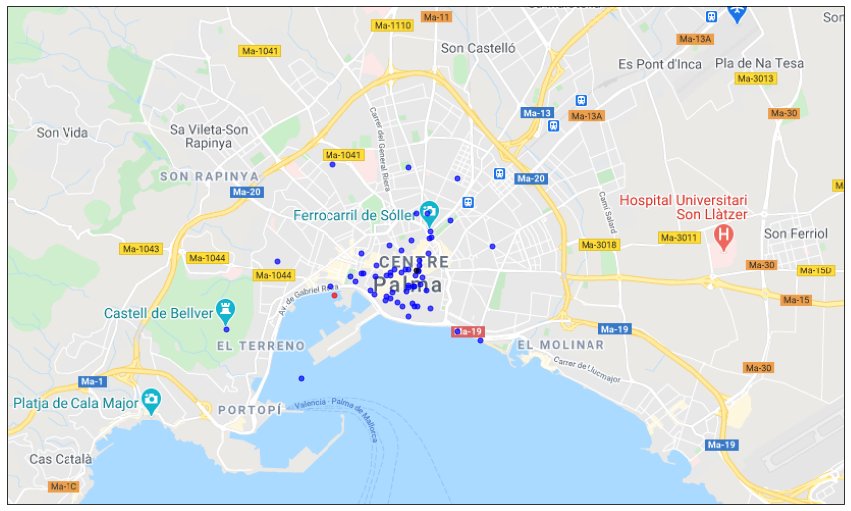

In [9]:
# values
latitude = topsightspalma.latitude.values
longitude = topsightspalma.longitude.values

# Map background
ffig = plt.figure(figsize=(15,20))

tiler = cimgt.GoogleTiles()
mercator = tiler.crs
ax = plt.axes(projection=mercator)

llcrnrlat=39.541089  # The lower left corner geographical latitude
llcrnrlon=2.582399   # The lower left corner geographical longitude
urcrnrlat=39.605874  # The upper right corner geographical latitude
urcrnrlon=2.723818   # The upper right corner geographical longitude


ax.set_extent([llcrnrlon,urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())

zoom = 13
ax.add_image(tiler, zoom )

plt.plot(longitude[1:], latitude[1:], marker='o', color='blue', markersize=5, lw=0,
         alpha=0.7, transform=ccrs.Geodetic())

plt.plot(longitude[0], latitude[0], marker='o', color='red', markersize=5, lw=0,
         alpha=0.7, transform=ccrs.Geodetic())

plt.plot(center["longitude"], center["latitude"], marker='o', color='black', markersize=5, lw=0,
         alpha=0.7, transform=ccrs.Geodetic())

plt.show()

## Utility

In [10]:
topsightspalma.head()

,place,description,latitude,longitude,stars,reviews
0,cruise ship,tourist cruise ship,39.568276,2.637640,0.000000,0.0
1,Catedral-Basílica de Santa María de Mallorca,Gothic place of worship on the seafront,39.567425,2.648299,4.674750,31176.0
2,Castell de Bellver,Hilltop 1300s castle for panoramic views,39.563814,2.619354,4.436243,10446.0
3,Royal Palace of La Almudaina,Historic palace of the Royal Family,39.567886,2.647022,4.420346,2310.0
5,Tren Soller,Scenic electric railway dating to 1912,39.576665,2.653782,4.396561,5757.0


In [11]:
maxreviews = topsightspalma.reviews.max()

Define utility as a sum between stars and reviews.

In [12]:
def utility(stars, reviews, maxreviews, alpha=0.5):
    return alpha*stars/5 + (1-alpha)*reviews/maxreviews

In [13]:
utilitycol = topsightspalma.apply(lambda row: utility(row.stars, row.reviews, maxreviews, 0.75), axis=1)
topsightspalma = topsightspalma.assign(utility=utilitycol.values)

Drop rows with empty latitude and longitude.

In [14]:
topsightspalma = topsightspalma.dropna(subset=["latitude", "longitude"])

In [15]:
topsightspalma.shape

(61, 7)

Check rows with empty stars and reviews.

In [16]:
emptyutility = topsightspalma[topsightspalma.loc[:,["stars", "reviews"]].isna().all(axis=1)].loc[:,["place"]]

In [17]:
emptyutility

,place
11,Born de Palma
19,Plaza Mayor de Palma de Mallorca
30,Paseo Marítimo (Palma de Mallorca)
37,Plaza de España
39,Gran Hotel
41,Rambla de Palma
50,Avenida Jaime III
60,Passeig Mallorca
89,Plaça del Rei Joan Carles I
90,tapas-tour


Define similar names and check if these names exit in the main dataframe.

In [18]:
likename = [["born"], ["mayor", "major"], ["marítimo", "marítim", "puerto", "port"], ["españa", "spain", "espanya"],
            ["gran"], ["rambla", "rambles", "ramblas"], ["jaume", "jaime"], ["passeig", "paseo", "riera"],
            ["joan", "juan"], ["tapas"]]
emptyutility["likename"] = likename
emptyutility["topsnames"]=[None]*emptyutility["place"].count()

In [19]:
def compare(likenames, alltopsnames):
    liketopnames = []
    for name in likenames:
        name = unidecode.unidecode(name.lower())
        boollist = [name in unidecode.unidecode(str_.lower()) for str_ in alltopsnames]
        ls = [x for x,y in zip(alltopsnames, boollist) if y==True]
        if ls: liketopnames.append(ls)
    if liketopnames:
        return sum(liketopnames, [])
    else:
        return None

In [20]:
alltopsnames = topsightspalma.dropna()["place"].tolist()
emptyutility["topsnames"] = emptyutility.apply(lambda row: compare(row["likename"], alltopsnames), axis=1)

In [21]:
emptyutility

,place,likename,topsnames
11,Born de Palma,[born],None
19,Plaza Mayor de Palma de Mallorca,"[mayor, major]","[Plaza Mayor, Roman Catholic Diocese of Majorca]"
30,Paseo Marítimo (Palma de Mallorca),"[marítimo, marítim, puerto, port]",[Port of Palma de Mallorca]
37,Plaza de España,"[españa, spain, espanya]",[Plaza España]
39,Gran Hotel,[gran],None
41,Rambla de Palma,"[rambla, rambles, ramblas]",None
50,Avenida Jaime III,"[jaume, jaime]",None
60,Passeig Mallorca,"[passeig, paseo, riera]",[Parque Sa Riera]
89,Plaça del Rei Joan Carles I,"[joan, juan]","[Museu Fundación Juan March, Palma, Mercado Gastronómico San Juan]"
90,tapas-tour,[tapas],None


The folowing pairs are the same places:
+ "Plaza Mayor de Palma de Mallorca" and "Plaza Mayor".
+ "Paseo Marítimo (Palma de Mallorca) and "Port of Palma de Mallorca".
+ "Plaza de España" and "Palza España".

Remove these places as places with empty utilities.

In [22]:
emptyutility = emptyutility.drop(emptyutility.index[[1,2,3]])
emptyutility = emptyutility[["place"]]

In [23]:
emptyutility

,place
11,Born de Palma
39,Gran Hotel
41,Rambla de Palma
50,Avenida Jaime III
60,Passeig Mallorca
89,Plaça del Rei Joan Carles I
90,tapas-tour


In case of an empty utility, set the utility as 0. <br> 
In future steps we must change it because the cruiseship should be the location with lowest utility.

In [24]:
euidx = emptyutility.index.tolist()
topsightspalma.loc[euidx, ["utility"]] = [0]*len(euidx)

Remove empty utilities (the 3 previous places) and reindex.

In [25]:
topsightspalma = topsightspalma.dropna(subset=["utility"])\
                               .reset_index(drop=True)

Search duplicate names.

In [26]:
def get_duplicates(row, alltopnames, stpwords):
    alltopnames_ = [' '.join([w for w in unidecode.unidecode(name.lower()).split() 
                              if len(w)>=3 and w not in stpwords]
                            ) for name in alltopnames]
    liketopnames = []
    lrow = unidecode.unidecode(row.lower())
    for name in lrow.split():
        name = ' '.join([w for w in name.split() if len(w)>=3])
        boollist = [name in unidecode.unidecode(str_.lower()).split() for str_ in alltopnames_]
        ls = [x for x,y in zip(alltopnames, boollist) if y==True]
        if ls: liketopnames.append(ls)
    if liketopnames:
        ll = list(set(sum(liketopnames, [])))
        if row in ll:
            ll.remove(row)
        return ll
    else:
        return None

In [27]:
alltopnames = topsightspalma["place"].tolist()
stpwords = ["can", "ca'n", "mallorca", "palma"]

duplicates = topsightspalma[["place"]].copy()
duplicates["dupcandidates"]=[None]*duplicates["place"].count()

duplicates["dupcandidates"] = duplicates.apply(lambda row: get_duplicates(row["place"], alltopnames, stpwords), axis=1)

The duplicate candidates are the following ones.

In [28]:
duplicates[duplicates["dupcandidates"].str.len() != 0 ]

,place,dupcandidates
1,Catedral-Basílica de Santa María de Mallorca,"[Iglesia de Santa Eulàlia, Església de Santa Eulàlia, Convent de Santa Clara]"
5,Es Baluard Museu d'Art Contemporani de Palma,"[Museu Diocesà de Mallorca, Museu Fundación Juan March, Palma]"
6,Plaza Mayor,"[Plaza Del Mercat, Plaza España]"
12,Mercat de l’Olivar,"[Mercat Pere Garau, Plaza Del Mercat]"
14,"Museu Fundación Juan March, Palma","[Es Baluard Museu d'Art Contemporani de Palma, Museu Diocesà de Mallorca, Mercado Gastronómico San Juan, Fundación Bartolomé March]"
15,Parc de la Mar,"[Consolat de Mar de Palma, Parc de les Estacions]"
16,Plaça de Cort,"[Plaça del Rei Joan Carles I, Plaça de toros de Palma]"
17,Mercado Gastronómico San Juan,"[Museu Fundación Juan March, Palma]"
18,Hort del Rei,"[Plaça del Rei Joan Carles I, Plaza Del Mercat]"
19,Església de Santa Eulàlia,"[Iglesia de Santa Eulàlia, Catedral-Basílica de Santa María de Mallorca, Convent de Santa Clara]"


After investigating some places, we can assume that these are the true duplicates:
+ 19 Església de Santa Eulàlia -- Iglesia de Santa Eulàlia
+ 20	Can Pere Antoni -- Playa Ca'n Pere Antoni

In [29]:
topsightspalma[topsightspalma["place"].isin(["Església de Santa Eulàlia",
                                            "Iglesia de Santa Eulàlia",
                                            "Can Pere Antoni",
                                            "Playa Ca'n Pere Antoni"])]

,place,description,latitude,longitude,stars,reviews,utility
19,Església de Santa Eulàlia,Church and history,39.569512,2.650901,4.107843,102.0,0.616994
20,Can Pere Antoni,Beach,39.562454,2.662287,4.191919,99.0,0.629582
43,Iglesia de Santa Eulàlia,Catholic church,39.569444,2.651111,4.448889,225.0,0.669138
44,Playa Ca'n Pere Antoni,Beach,39.563585,2.658419,4.142349,281.0,0.623606


In duplicate places, we can define stars as the mean of stars, reviews as the sum of reviews and apply our custom utility function.

In [30]:
def mean_(idxs, col):
    duplist = topsightspalma.loc[idxs, [col]]
    return np.mean(duplist)[0]

In [31]:
def sum_(idxs, col):
    duplist = topsightspalma.loc[idxs, [col]]
    return np.sum(duplist)[0]

In [32]:
topsightspalma.loc[[19], ["stars"]]   = mean_([19,43], "stars")
topsightspalma.loc[[19], ["reviews"]] = sum_([19,43], "reviews")

topsightspalma.loc[[20], ["stars"]]   = mean_([20,44], "stars")
topsightspalma.loc[[20], ["reviews"]] = sum_([20,44], "reviews")

topsightspalma = topsightspalma.drop([43,44]).reset_index(drop=True)

topsightspalma["utility"] = topsightspalma.apply(lambda row: utility(row.stars, row.reviews, maxreviews)
                                                 if row.place in ["Església de Santa Eulàlia", "Can Pere Antoni"]
                                                 else row.utility
                                                 , axis=1)

In case of 0 utility, we set utility equal to <img src="https://latex.codecogs.com/svg.latex?&space;\text{round}\left(\frac{\min(\text{utility})}{4},\ 2\right)." title="\ut" />

With Palma data, these value is 0.1. <br>

We change the zero utilities because the cruise ship should be the only place with zero utility (due to our definition of the model).

In [33]:
minutility = topsightspalma[topsightspalma["utility"] > 0].utility.min()
aux_utility = round(minutility/4,2)  # 0.1

In [34]:
topsightspalma["utility"] = topsightspalma.apply(lambda row: aux_utility 
                                                             if (row.utility == 0 and row.place != "cruise ship")
                                                             else row.utility
                                                           , axis=1)

In [35]:
topsightspalma.head()

,place,description,latitude,longitude,stars,reviews,utility
0,cruise ship,tourist cruise ship,39.568276,2.637640,0.000000,0.0,0.000000
1,Catedral-Basílica de Santa María de Mallorca,Gothic place of worship on the seafront,39.567425,2.648299,4.674750,31176.0,0.951213
2,Castell de Bellver,Hilltop 1300s castle for panoramic views,39.563814,2.619354,4.436243,10446.0,0.749203
3,Royal Palace of La Almudaina,Historic palace of the Royal Family,39.567886,2.647022,4.420346,2310.0,0.681576
4,Tren Soller,Scenic electric railway dating to 1912,39.576665,2.653782,4.396561,5757.0,0.705649


In [36]:
topsightspalma.to_csv('palmadata/palmapointsofinterest_cleaned.csv', index=False)